# Pneumonia Detection


# Dataset

- [kaggle Chest X-Ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
- 5,856 X-Ray images (JPEG)
- 2 categories (Pneumonia/Normal)
- Organized into 3 folders (train, test, val)
- Datset size: 1.2 GB
- From the hospital for female and children(1~5 yr) in China

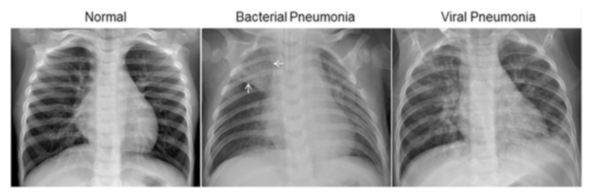

## Baseline Kernal

- [Overall](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)

- 1) 실험 환경 set-up
    - batch size
    - epoch
- 2) 데이터 준비하기
    - data augmentation
- 3) 데이터 시각화
    - show_batch() 함수 이용해서 augmentation 결과 확인
- 4) CNN 모델링
    - conv filter, 채널 개수, activation, 모델 구조 등을 바꿔보기
    - batch normalization과 dropout 둘 중 하나만 써보거나
    - dropout 비율 조정해보기
- 5) 데이터 imbalance 처리
    - class_weight 처리를 안 하면 어떻게 될까?
    - recall을 강조하기 위해 더 강화할 수 있을까?
- 6) 모델 훈련
    - optimizer, learning rate 등 조정
- 7) 결과 확인, 시각화
    - 분석을 더 자세히 해보기

In [58]:
import math
import os
import random
import re

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
# for faster data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY image size
IMAGE_SIZE = [180, 180]

# path for datatset
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/aiffel_projects/exploration/E11_chest_xray/data')
TRAIN_PATH = ROOT_PATH + '/train/*/*'
VAL_PATH = ROOT_PATH + '/val/*/*'
TEST_PATH = ROOT_PATH + '/test/*/*'

# hyperparameters for training
BATCH_SIZE = 8
EPOCHS = 35

print(ROOT_PATH)

/aiffel/aiffel/aiffel_projects/exploration/E11_chest_xray/data


In [60]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train dataset:", len(train_filenames))
print("test dataset:", len(test_filenames))
print("val dataset:", len(val_filenames))

train dataset: 5216
test dataset: 624
val dataset: 16


### Split train and validation dataset with 8:2 ratio

In [61]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train dataset:", len(train_filenames))
print("val dataset:", len(val_filenames))

train dataset: 4185
val dataset: 1047


In [62]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}\n')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/aiffel_projects/exploration/E11_chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg

Pneumonia image path
/aiffel/aiffel/aiffel_projects/exploration/E11_chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [63]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [64]:
# tf.data 인스턴스 생성
# tf.data로 배치처리 작업을 효율적으로 할 수 있다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [65]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### Produce Label data

- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만든다.

In [66]:
# 파일 경로의 끝에서 두번째 부분을 확인
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    # 폐렴이면 양성(True), 노말이면 음성(False)
    return parts[-2] == "PNEUMONIA"

In [67]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    # 이미지를 uint8 tensor로 수정
    img = tf.image.decode_jpeg(img, channels=3) 
    # float32 타입으로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # 이미지 사이즈를 IMAGE_SIZE로 수정
    img = tf.image.resize(img, IMAGE_SIZE) 
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

In [68]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [69]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [70]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("test dataset: ", TEST_IMAGE_COUNT)

test dataset:  624


In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

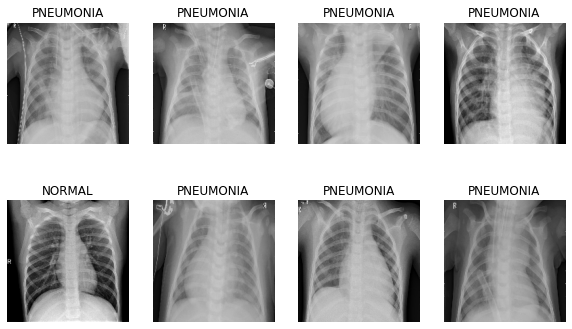

In [72]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,int(BATCH_SIZE*0.8)))
    
    for n in range(BATCH_SIZE):
        ax = plt.subplot(math.ceil(BATCH_SIZE/4),4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

- Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용

In [73]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [74]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [75]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.4),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리

In [76]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Model Train

In [84]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [78]:
callback = EarlyStopping(monitor='precision', patience=5)

In [85]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_33 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_34 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_17 (Dropout)         (None, 11, 11, 128)     

In [86]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
#         callbacks=[callback],
        verbose=1
    )

Epoch 1/35
523/523 [==============================] - 48s 77ms/step - loss: 0.5371 - accuracy: 0.7225 - precision: 0.9265 - recall: 0.6824 - val_loss: 0.8497 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/35
523/523 [==============================] - 39s 75ms/step - loss: 0.3065 - accuracy: 0.8653 - precision: 0.9594 - recall: 0.8562 - val_loss: 0.2700 - val_accuracy: 0.8981 - val_precision: 0.9896 - val_recall: 0.8702
Epoch 3/35
523/523 [==============================] - 39s 75ms/step - loss: 0.2626 - accuracy: 0.8980 - precision: 0.9680 - recall: 0.8923 - val_loss: 0.5729 - val_accuracy: 0.7644 - val_precision: 1.0000 - val_recall: 0.6781
Epoch 4/35
523/523 [==============================] - 39s 75ms/step - loss: 0.2643 - accuracy: 0.8892 - precision: 0.9716 - recall: 0.8782 - val_loss: 0.1173 - val_accuracy: 0.9577 - val_precision: 0.9774 - val_recall: 0.9646
Epoch 5/35
523/523 [==============================] - 39s 75ms/step - loss: 0.2255 - accuracy: 0

## Evaluate

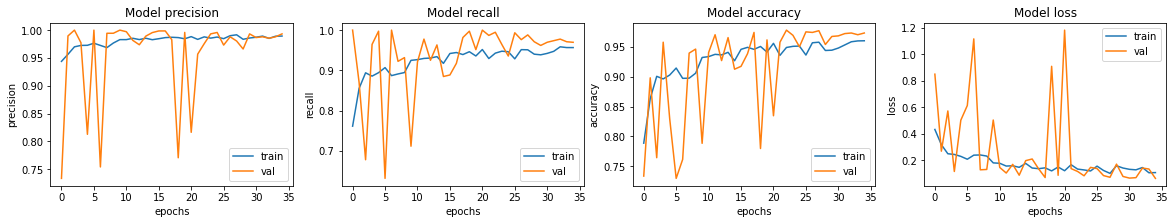

In [87]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [88]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'\nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 41ms/step - loss: 0.8875 - accuracy: 0.8301 - precision: 0.7898 - recall: 0.9923

Loss: 0.8875181674957275,
Accuracy: 0.8301281929016113,
Precision: 0.7897959351539612,
Recall: 0.9923076629638672


In [90]:
IMG_ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/aiffel_projects/exploration/E11_chest_xray/images')

# Develop Model Performance

- 다양한 시도 중 accuracy, precision이 개선되는 과정만 기록하였다.

## 1) Batch size, Epochs 조정

### - Base

- epochs=25
- batch size=16

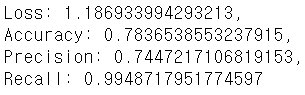

In [91]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '1.png')
Image(IMG_PATH)

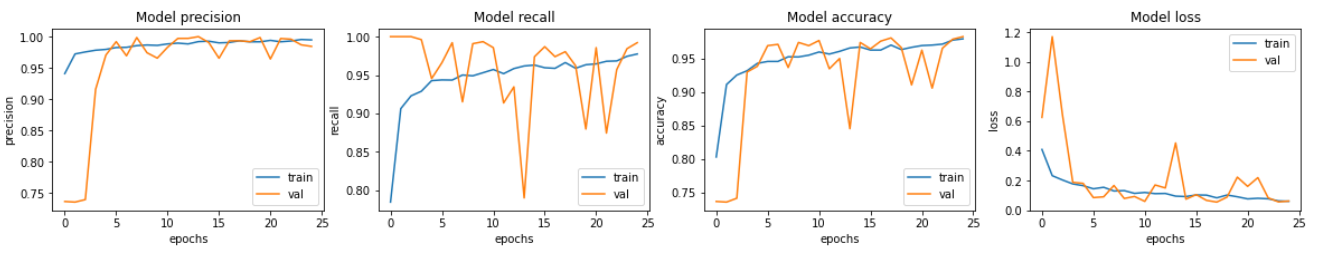

In [92]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '2.png')
Image(IMG_PATH)

### - First Try

- epochs=50
- earlystopping
- batch size=10

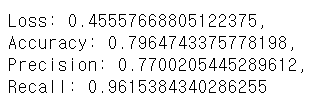

In [93]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '3.png')
Image(IMG_PATH)

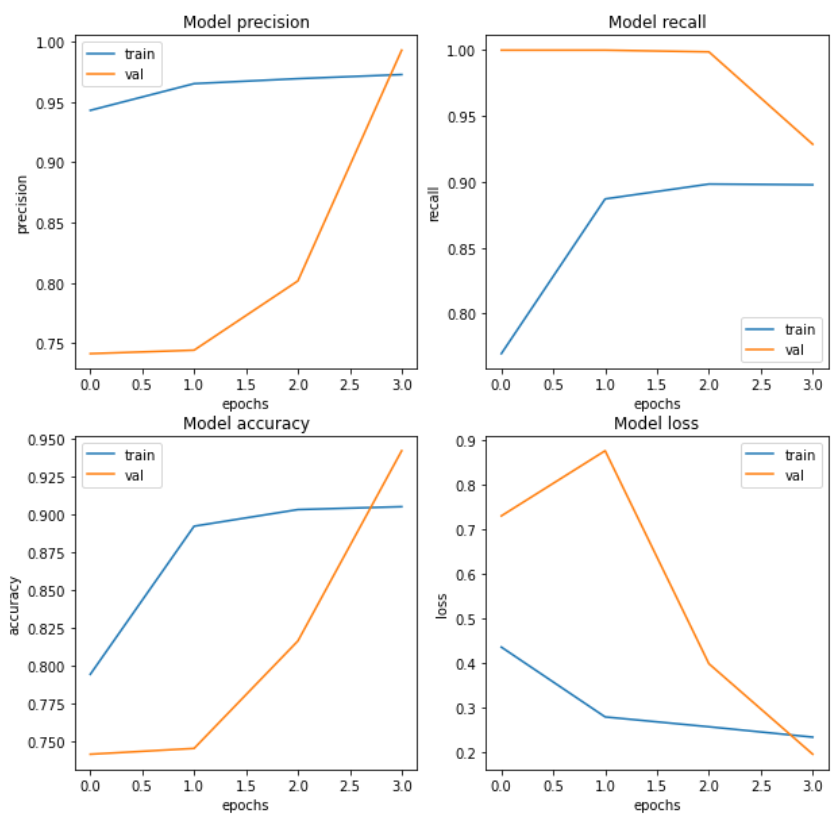

In [94]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '4.png')
Image(IMG_PATH)

### - Second try
- batch size=8
- epochs=30
- without earlystopping

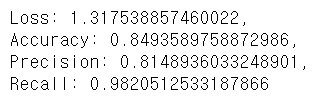

In [95]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '5.png')
Image(IMG_PATH)

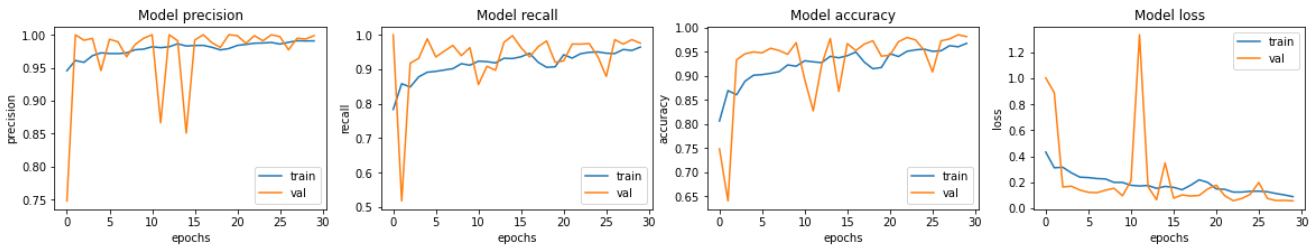

In [96]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '6.png')
Image(IMG_PATH)

## 2) Regularization


### 2-1) Dropout Ratio

### - Base

- 성능은 위와 동일

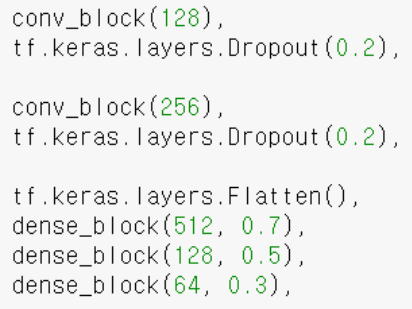

In [97]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '7.png')
Image(IMG_PATH)

### - First

- dropout ratio 아래와 같이 조정
- epochs=22

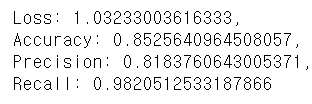

In [98]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '8.png')
Image(IMG_PATH)

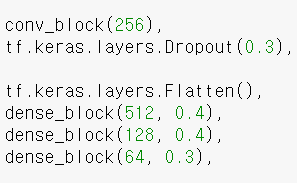

In [99]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '9.png')
Image(IMG_PATH)

### - Second

- **WITHOUT batch-normalizaiton**
- 나머지는 그대로
- precision과 recall이 거의 0에 가깝게 나왔다..

### - Third

- WITH batch-normalization
- **WITHOUT dropout**
- precision과 accuracy가 70%대로 떨어졌다.

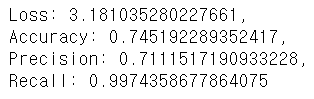

In [100]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '10.png')
Image(IMG_PATH)

## 3) Data Augmentation

In [71]:
# 좌우 반전 data augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### - First

- epochs=22
- 나머지 그대로

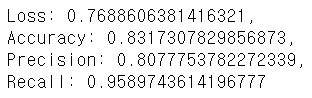

In [101]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '11.png')
Image(IMG_PATH)

### - Second

- epochs=35
- 나머지 그대로

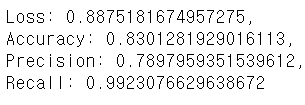

In [102]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '12.png')
Image(IMG_PATH)

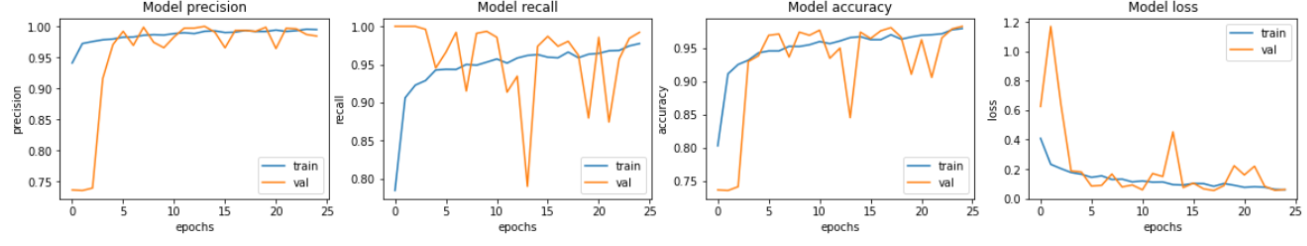

In [103]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '13.png')
Image(IMG_PATH)

## Conclusion

- Performance Analysis
    - 우선 페렴에 걸렸는데 음성이라고 진단할 확률(FP)이 낮아야 하고, 폐렴에 걸린 사람을 양성으로 진단할 확률(TP)이 높아야 한다.
    - 따라서 모델의 성능을 판단함에 있어 accuracy와 precision을 가장 중요한 지표로 고려하였다.

- Data Augmentation
    - 동일한 조건에서 오히려 성능이 80% 초반대로 조금 떨어졌다.
    - 학습 시간은 더 오래 걸렸다.
    - epochs을 늘렸더니 일부 성능 지표가 약간 개선되었지만, precision의 경우 더 떨어졌고, 때문에 더 좋은 결과를 얻었다고 보기는 어려웠다.

- Regularization
    - Batch Normalization을 수행하지 않고 dropout만 수행한 경우, 정확도와 정밀도가 0에 가까울 정도로 낮게 나왔다.
    - 반면 Batch Normalization을 수행하고, dropout을 생략한 경우에는 약 10%대의 정확도 및 정밀도가 떨어졌다.

- Modeling
    - 이번에는 유독 epochs에 따른 정확도, 정밀도 차이가 매우 컸다. 그렇다고 epochs이 커질수록 무조건 과적합이 발생하는 것도 아니어서 기준을 잡기가 어려웠다.
    - 그래서인지 Earlystopping을 이용하는 것이 효과가 없었다. 오히려 history 그래프를 보고 적당한 epochs을 적용한 것이 더 성능이 좋았다.
    
    
- **Best Choice**
    - Batch size=8
    - Epochs=22
    - Batch normalization=True
    - Dropout=True
        - ratio는 아래 이미지 참고
    - Data Augmentation=False
    - 나머지는 Baseline 코드와 동일한 조건

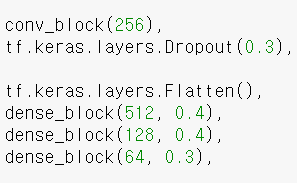

In [104]:
IMG_PATH = os.path.join(IMG_ROOT_PATH, '14.png')
Image(IMG_PATH)